# Spatial Correlations of bacterial suspensions

Here we use spatial correlaitons (orientation, velocity and pixel intensity) to identify the transition from disordered phase to ordered phase. 

We also compare the concentration dependence of correlation length with that of GNF scaling exponent $\alpha$.

## 1. Packages and presets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from myImageLib import dirrec, bestcolor, bpass, wowcolor
from skimage import io, measure, util
import pandas as pd
from scipy.signal import savgol_filter, medfilt
import os
import corrLib
from scipy.signal import savgol_filter
import matplotlib as mpl
from scipy.optimize import curve_fit
from miscLib import label_slope
from corrLib import density_fluctuation
from scipy import signal
from scipy.interpolate import griddata
import matplotlib
import pandas as pd
import time
from corr_utils import *
from pivLib import PIV1
import typesetting.main as tm
tm.prl('1-column-2-panel')

## 2. intensity, orientation and velocity spatial correlation

### 2.1 Helper functions

- Exponential function: for fitting the spatial correlations 
- corr_length: extract correlation length
- xy_to_r: spatial correlation data was originally recorded in (x, y, CA, CV). This function converts the x, y to r by 
$$ r = \sqrt{x^2+y^2} $$

    **Note:** (x, y) in the data starts from the first nonzero distance (step, step), where as the correlation value (CA, CV) starts from distance (0, 0). Here, we manually adjust the (x, y) by 
$$ x, y = x-step, y-step $$
    to get meaningful spatial correlation data.

- average_data: take the average of all data in given directory

**Fit data with exponential**

The correlation functions are all identified as exponential decay. In order to determine the length scale of the correlation function, I need to fit the functions with exponential $$y = be^{-ax}$$
```Python
def exp(x, a):
    return np.exp(-a*x)
```

**Extract correlation length**

The correlation functions are characterized by an exponential decay. To extract correlation lengths, we set the criterion to be the first point where the correlation function is below $1/e$. Define function below:
```Python
def corr_length(data, fitting_range=None):
    """
    Args:
    data -- dataframe with columns (R, C), where R has pixel as unit
    fitting_range -- (optional) can be None, int or list of two int
    
    Returns:
    cl -- correlation length of given data (pixel)
    fit -- fitting result object, return value of curve_fit
    """
    ...
    return cl, fit
```

**Convert function of xy to that of r**

My code (corrS and corrI) calcualtes the correlation function as a function of x and y first. When studying isotropic systems, it is usually desired to convert the function of xy to that of r, the distance. Define function below:
```Python
def xy_to_r(corr_xy):
    """
    Note, this version of function converts the xy data where x, y start from (step, step) instead of (0, 0).
    When the corr functions are changed, this function should not be used anymore. 
    Check carefully before using.
    
    Args:
    corr_xy -- DataFrame of (X, Y, ...)
    
    Returns:
    corr_r -- DataFrame (R, ...)
    """
    ...
    return corr_r
```

**Average multiple correlation function datasets**

Typically, for one set of conditions, I have multiple runs of experiments. When presenting all these data, I need to average them and estimate the error of this set. Define function below:
```Python
def average_data(directory, columns=['CA', 'CV']):
    """
    Take the average of all data in given directory
    
    Args:
    directory -- folder which contains *.csv data, with columns
    columns -- (optional) list of column labels of columns to be averaged
    
    Returns:
    averaged -- DataFrame with averaged data
    """
    ...
    return averaged
```

**


In [3]:
# test xy_to_r
corr_xy = pd.read_csv(r'I:\Github\Python\Correlation\test_images\CAV\cav_result\900-901.csv')
corr_r = xy_to_r(corr_xy)
corr_r.head()

,X,Y,CA,CV,R
0,25.0,25.0,1.000000,1.000000,0.0
1,50.0,25.0,0.912503,0.947867,25.0
2,75.0,25.0,0.792586,0.855965,50.0
3,100.0,25.0,0.685544,0.754280,75.0
4,125.0,25.0,0.583561,0.646617,100.0


In [2]:
# test average_data
d = r'I:\Github\Python\Correlation\test_images\CAV\cav_result'
tic = time.monotonic()
averaged = average_data(d, columns=['CA', 'CV'])
toc = time.monotonic()
print('time needed for 2 files: {:.3} ms'.format((toc-tic)*1000))
print(averaged.head())

time needed for 2 files: 79.0 ms
         CA        CV      X     Y
0  1.000000  1.000000   25.0  25.0
1  0.914361  0.948507   50.0  25.0
2  0.795402  0.857086   75.0  25.0
3  0.687169  0.756254  100.0  25.0
4  0.585534  0.650149  125.0  25.0


## 2.2 Concentration correlation

#### 2.2.1 Plot concentration correlation functions

Since the plot functions for concentration, orientation and velocity are very similar, I integrate them into one function ```plot_correlation(data, mpp, lb)```, where data should have (R, C, conc). 
```Python
def plot_correlation(data, plot_cols=['R', 'C'], xlim=None, mpp=0.33, lb=3, plot_raw=False):
    """
    Plot correlation data. Here we plot the exponential function fitting instead of raw data so that the curve look better.

    Args:
    data -- DataFrame (R, C, conc)
    plot_cols -- specify columns to plot. The first column should be distance and the second is correlation
    xlim -- trim the xdata, only use those in the range of xlim
    mpp -- microns per pixel 
    lb -- bacteria size in um

    Returns:
    ax -- the axis of plot, one can use this handle to add labels, title and other stuff
    cl_data -- correlation length data, DataFrame with columns (conc, cl)
    """
    ...
    return ax, cl_data
```

Text(0, 0.5, '$C_{n}$')

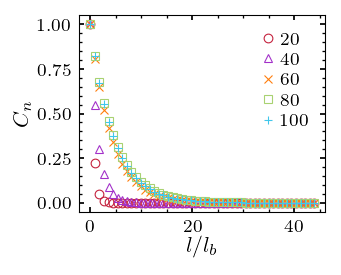

In [5]:
# test plot_correlation
data = pd.read_csv(r'I:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv')
ax, cl_data = plot_correlation(data, xlim=400)
ax.set_xlabel('$l/l_b$', size=10)
ax.set_ylabel('$C_{n}$', size=10)

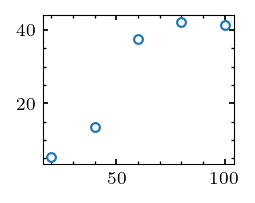

In [6]:
plt.plot(cl_data['conc'], cl_data['cl'], mec=bestcolor(0), ls='',
                marker='o', mfc=(0,0,0,0), markersize=4, markeredgewidth=1)

#### 2.2.2 New data Aug 2020

48.01417462285436

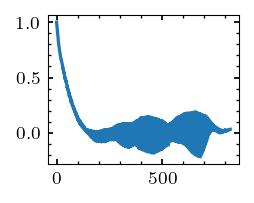

In [102]:
data = pd.read_csv(r'E:\moreData\08032020\corr_imseq\01\3096.csv')
plt.plot(data['R'], data['C'])
cl, fit = corr_length(data, fitting_range=500)
cl

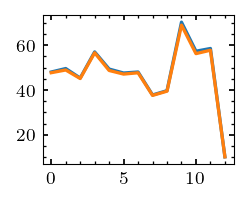

In [19]:
# sample 10 frames out of the last 1/3 of frames
date = '08062020'
corr_data_path = r'E:\moreData\{}\corr_imseq'.format(date)
average_cl = []
average_func_cl = []
numbers = data_log()[date]['num']
for n in numbers:    
    corr_data_path_num = os.path.join(corr_data_path, '{:02d}'.format(n))
    l = corrLib.readdata(corr_data_path_num)
    clL = []
    count = 0
    for num, i in l.iterrows():        
        if num > int(len(l)*2/3):
            data = pd.read_csv(i.Dir)
            # two ways of averaging: 1) calculate cl for each frame, and average cl's
            #                        2) average all correlation functions, then fit for cl
            # Way 1
            cl, fit = corr_length(data, fitting_range=500)
            clL.append(cl)
            # Way 2
            if count == 0:
                temp = data
            else:
                temp += data
            count += 1
    cl, fit = corr_length(temp/count, fitting_range=500)    
    average_cl.append(np.array(clL).mean())
    average_func_cl.append(cl)
plt.plot(numbers, average_cl)
plt.plot(numbers, average_func_cl)

In [20]:
summary = pd.DataFrame({'sample': numbers, 'cl': average_func_cl})
summary.to_csv(os.path.join(corr_data_path, 'summary.csv'), index=False)

**Comment:** the correlation length for 0 concentration is apparently wrong, while others look fine.

## 2.3 Orientation and velocity correlations

#### 2.3.1 Plot orientation and velocity correlations

**Construct all-in-one data:**
    
Before calling a function which plots the data, we first reorganize the data in a DataFrame with (R, CA, CV, conc) by using

- average_data(directory)
- xy_to_r(corr_xy)
- assign conc column

In [8]:
# First average data over time for each sample
folder = r'D:\density_fluctuations\Dynamics_raw\cav_result'
l = next(os.walk(folder))[1]
for s in l:
    d = os.path.join(folder, s)
    avg = average_data(d, columns=['CA', 'CV'])
    avg.to_csv(os.path.join(folder, s+'.csv'), index=False)

In [54]:
# convert from xy to r and save in corresponding folder
folder = r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\xy'
l = corrLib.readdata(folder)
for num, i in l.iterrows():
    conc = i.Name.split('-')[0]
    dest_folder = folder.replace('xy', conc)
    data_xy = pd.read_csv(i.Dir)
    data_r = xy_to_r(data_xy)
    data_r.to_csv(os.path.join(dest_folder, i.Name+'.csv'), index=False)

In [57]:
# average over concentration and combine into one file corrAV.csv
sfL = ['20', '40', '60', '80', '100']
folder = r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr'
for num, s in enumerate(sfL):
    d = os.path.join(folder, s)
    avg = average_data(d, columns=['CA', 'CV']).assign(conc=s)
    if num == 0:
        data = avg
    else:
        data = data.append(avg)
data.to_csv(os.path.join(folder, 'corrAV.csv'), index=False)

<font color='green'><b>Here, corrAV.csv is the all-in-one orientation and velocity correlation data, with columns (R, CA, CV)</b></font>

**Plot orientation correlation**

Text(0, 0.5, '$C_{A}$')

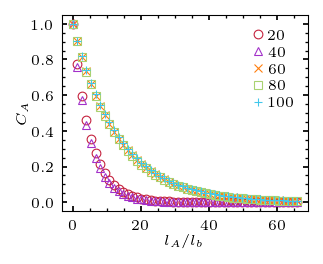

In [176]:
data = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorrA.csv')
data.R = data.R - data.R.min()
ax, cl_data = plot_correlation(data, xlim=600, plot_cols=['R', 'C'])
ax.set_xlabel('$l_A/l_b$')
ax.set_ylabel('$C_{A}$')

Text(0, 0.5, '$l_A/l_b$')

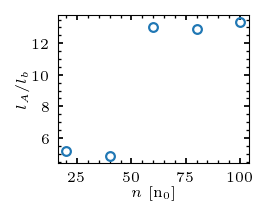

In [177]:
# this cell uses cl_data variable which comes from the cell above, run the above cell before this one, otherwise error will occur
# or you may be plotting cl_data from other data
plt.plot(cl_data['conc'], cl_data['cl']*0.33/3, mec=bestcolor(0), ls='',
                marker='o', mfc=(0,0,0,0), markersize=4, markeredgewidth=1)
plt.xlabel('$n$ [n$_0$]')
plt.ylabel('$l_A/l_b$')

**Plot velocity correlation**

Text(0, 0.5, '$C_{v}$')

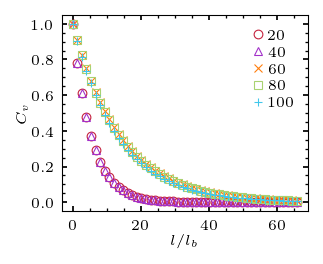

In [174]:
data = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorrV.csv')
data.R = data.R - data.R.min()
ax, cl_data = plot_correlation(data, xlim=600, plot_cols=['R', 'C'])
ax.set_xlabel('$l/l_b$')
ax.set_ylabel('$C_{v}$')

Text(0, 0.5, '$l_A/l_b$')

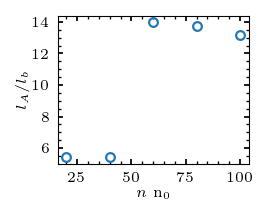

In [175]:
# this cell uses cl_data variable which comes from the cell above, run the above cell before this one, otherwise error will occur
# or you may be plotting cl_data from other data
plt.plot(cl_data['conc'], cl_data['cl']*0.33/3, mec=bestcolor(0), ls='',
                marker='o', mfc=(0,0,0,0), markersize=4, markeredgewidth=1)
plt.xlabel('$n$ n$_0$')
plt.ylabel('$l_A/l_b$')

#### 2.3.2 New data Aug 2020

90.9232168817372


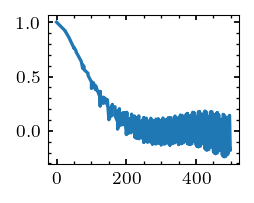

In [117]:
# data = pd.read_csv(r'temp_data\05-3564.csv').rename(columns={'CV': 'C'})
data = pd.read_csv(r'E:\moreData\08042020\cav_imseq\05\2592-2593.csv').rename(columns={'CV': 'C'})
data = xy_to_r(data).sort_values(by=['R'])
data = data.loc[data.R<500]
clV, fit = corr_length(data, fitting_range=None)
plt.plot(data['R'], data['C'])
print(clV)

125.82792526710855


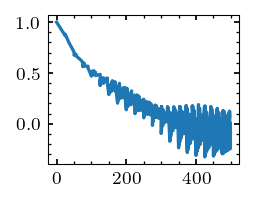

In [141]:
data = pd.read_csv(r'temp_data\3384-3385.csv').rename(columns={'CV': 'C'})
# data = pd.read_csv(r'E:\moreData\08042020\cav_imseq\05\3564-3565.csv').rename(columns={'CV': 'C'})
data = xy_to_r(data).sort_values(by=['R'])
data = data.loc[data.R<500]
clV, fit = corr_length(data, fitting_range=500)
plt.plot(data['R'], data['C'])
print(clV)

In [88]:
date = '08032020'
corr_data_path = r'E:\moreData\{}\cav_imseq'.format(date)
average_clA = []
average_clV = []
average_func_clA = []
average_func_clV = []
numbers = data_log()[date]['num']
for n in numbers:
    corr_data_path_num = os.path.join(corr_data_path, '{:02d}'.format(n))
    l = corrLib.readdata(corr_data_path_num)
    clAL = []
    clVL = []
    count = 0
    for num, i in l.iterrows():
        if num > int(len(l)*2/3):
            data_raw = pd.read_csv(i.Dir) # X Y CA CV
            data_AV = xy_to_r(data_raw).sort_values(by=['R'])
            # Two ways: 1) average correlation length
            #           2) average correlation function
            # Way 1
            clA, fit = corr_length(data_AV.rename(columns={'CA': 'C'}), fitting_range=500)
            clV, fit = corr_length(data_AV.rename(columns={'CV': 'C'}), fitting_range=500)
            clAL.append(clA)
            clVL.append(clV)
            # Way 2
            if count == 0:
                temp = data_AV
            else:
                temp += data_AV
            count += 1
    clA, fit = corr_length((temp/count).rename(columns={'CA': 'C'}), fitting_range=500)
    clV, fit = corr_length((temp/count).rename(columns={'CV': 'C'}), fitting_range=500)
    average_clA.append(np.array(clAL).mean())
    average_clV.append(np.array(clVL).mean())
    average_func_clA.append(clA)
    average_func_clV.append(clV)

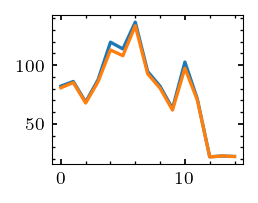

In [89]:
plt.plot(numbers, average_clV)
plt.plot(numbers, average_func_clV)

In [90]:
summary = pd.DataFrame({'sample': numbers, 'clA': average_func_clA, 'clV': average_func_clV})
summary.to_csv(os.path.join(corr_data_path, 'summary.csv'), index=False)

In [22]:
data_raw = pd.read_csv(r'E:\moreData\08032020\cav_imseq\14\0068-0069.csv') # X Y CA CV
data_AV = xy_to_r(data_raw).sort_values(by=['R'])
data_AV = data_AV.loc[data_AV.R<500]
clA, fit = corr_length(data_AV.rename(columns={'CA': 'C'}), fitting_range=500)
clA

1.0496471164183367

Text(0, 0.5, 'C')

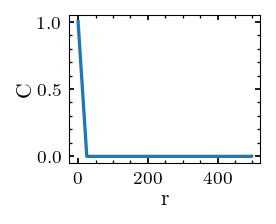

In [24]:
plt.plot(data_AV['R'], data_AV['CA'])
plt.xlabel('r')
plt.ylabel('C')

In [68]:
pivData = pd.read_csv(r'E:\moreData\08032020\piv_imseq\14\0096-0097.csv')

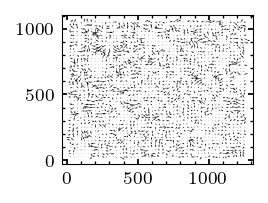

In [69]:
plt.quiver(pivData.x, pivData.y, pivData.u, pivData.v)

In [64]:
col = len(pivData.x.drop_duplicates())
row = len(pivData.y.drop_duplicates())
X = np.array(pivData.x).reshape((row, col))
Y = np.array(pivData.y).reshape((row, col))
U = np.array(pivData.u).reshape((row, col))
V = np.array(pivData.v).reshape((row, col))

In [30]:
def corrS(X, Y, U, V):
    row, col = X.shape
    vsq = 0
    CA = np.zeros((row, col))
    CV = np.zeros((row, col))
    for i in range(0, row):
        for j in  range(0, col):
            vsq += U[i, j]**2 + V[i, j]**2
    for xin in range(0, col):
        for yin in range(0, row):
            count = 0
            CAt = 0
            CVt = 0
            for i in range(0, col-xin):
                for j in range(0, row-yin):
                    ua = U[j, i]
                    va = V[j, i]
                    ub = U[j+yin, i+xin]
                    vb = V[j+yin, i+xin]
                    CAt += (ua*ub+va*vb)/((ua**2+va**2)*(ub**2+vb**2))**.5
                    CVt += ua*ub + va*vb
                    count += 1
            CA[yin, xin] = CAt / count
            CV[yin, xin] = CVt / vsq     
    return CA, CV

In [51]:
CA, CV = corrS(X, Y, U, V)

In [65]:
x, y, ca, cv = corrLib.corrS(X, Y, U, V)

In [66]:
df_old = pd.DataFrame().assign(X=X.flatten(), Y=Y.flatten(), C=CV.flatten())
df_new = pd.DataFrame().assign(X=x.flatten(), Y=y.flatten(), C=cv.flatten())
df_old_r = xy_to_r(df_old).sort_values(by=['R'])
df_new_r = xy_to_r(df_new).sort_values(by=['R'])

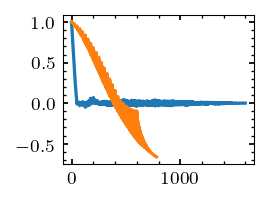

In [67]:
plt.plot(df_old_r.R, df_old_r.C)
plt.plot(df_new_r.R, df_new_r.C)

In [ ]:
cav_data = pd.read_csv()

**Comment:** there are unexpected observations in the correlation length calculation, 1) highest correlation length happens at 60 n$_0$ instead of 80 n$_0$, 2) correlation length for same sample varies too much. Double check the validity of PIV.

**<font color='red'>Important issue:</font>** Velocity correlation length for blank sample is unexpectedly high. I've checked:
- corrS function: and found for same PIV data, corrS always give same results. Then I realize it could be the PIV, so I checked
- PIV: and found the PIV was indeed different from the past. Two possible reasons:
    - I used image with background subtraction
    - I updated PIV package

### 2.3.3 Test PIV without smoothing

In [77]:
img_folder = r'temp_data\piv_nosmooth\14'
I0 = io.imread(os.path.join(img_folder, '0098.tif'))
I1 = io.imread(os.path.join(img_folder, '0099.tif'))
pivData = PIV1(I0, I1, 50, 25, 0.033, smooth=False)

corr length: 19.48 px


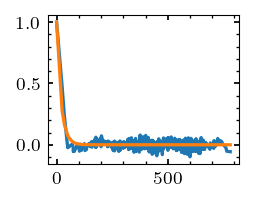

In [78]:
col = len(pivData.x.drop_duplicates())
row = len(pivData.y.drop_duplicates())
X = np.array(pivData.x).reshape((row, col))
Y = np.array(pivData.y).reshape((row, col))
U = np.array(pivData.u).reshape((row, col))
V = np.array(pivData.v).reshape((row, col))
x, y, CA, CV = corrLib.corrS(X, Y, U, V)

data = pd.DataFrame().assign(X=x.flatten(), Y=y.flatten(), CA=CA.flatten(), CV=CV.flatten())
data1 = xy_to_r(data).sort_values(by=['R'])
cl, fit = corr_length(data1.rename(columns={'CA': 'C'}), fitting_range=500)
print('corr length: {:.2f} px'.format(cl))
plt.plot(data1.R, data1.CV)
plt.plot(data1.R, exp(data1.R, fit[0][0]))

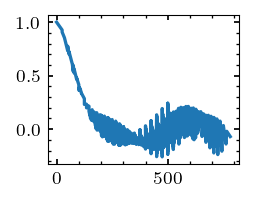

In [162]:
help(xy_to_r)

Help on function xy_to_r in module corr_utils:

xy_to_r(corr_xy)
    Note, this version of function converts the xy data where x, y start from (step, step) instead of (0, 0).
    When the corr functions are changed, this function should not be used anymore. 
    Check carefully before using.
    
    Args:
    corr_xy -- DataFrame of (X, Y, ...)
    
    Returns:
    corr_r -- DataFrame (R, ...)



### 2.4 Plot all correlation lengths in the same axis

Text(0, 0.5, '$C_v$')

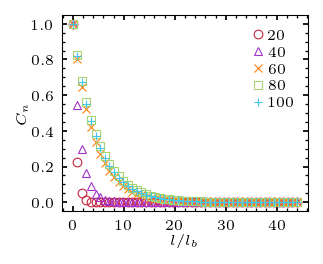

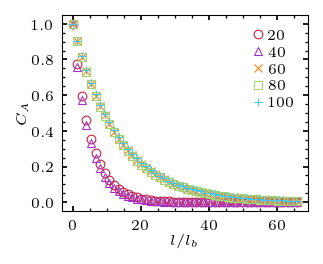

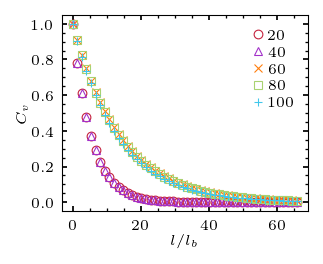

In [178]:
data = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv')
data.R = data.R - data.R.min()
ax, cl_data = plot_correlation(data, xlim=400)
ax.set_xlabel('$l/l_b$')
ax.set_ylabel('$C_n$')
data = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorrA.csv')
data.R = data.R - data.R.min()
ax, cla_data = plot_correlation(data, xlim=600)
ax.set_xlabel('$l/l_b$')
ax.set_ylabel('$C_A$')
data = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorrV.csv')
data.R = data.R - data.R.min()
ax, clv_data = plot_correlation(data, xlim=600)
ax.set_xlabel('$l/l_b$')
ax.set_ylabel('$C_v$')

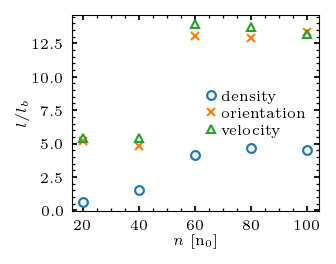

In [179]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(cl_data['conc'], cl_data['cl']*0.33/3, mec=bestcolor(0), ls='', label='density',
                marker='o', mfc=(0,0,0,0), markersize=4, markeredgewidth=1)
ax.plot(cla_data['conc'], cla_data['cl']*0.33/3, mec=bestcolor(1), ls='', label='orientation',
                marker='x', mfc=(0,0,0,0), markersize=4, markeredgewidth=1)
ax.plot(clv_data['conc'], clv_data['cl']*0.33/3, mec=bestcolor(2), ls='', label='velocity',
                marker='^', mfc=(0,0,0,0), markersize=4, markeredgewidth=1)
ax.set_xlabel('$n$ [n$_0$]')
ax.set_ylabel('$l/l_b$')
ax.legend()

**Plot concentration correlation length on a different scale**

Since concentration correlation length is much smaller than other two, I'd like to plot it on a different scale to highlight the similarity between the three quantities -- sudden increase at the onset of collective motion.

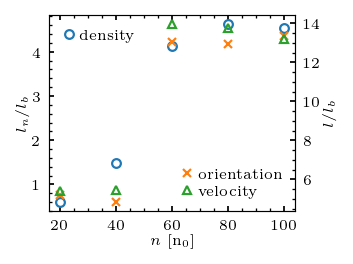

In [180]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(cl_data['conc'], cl_data['cl']*0.33/3, mec=bestcolor(0), ls='', label='density',
                marker='o', mfc=(0,0,0,0), markersize=4, markeredgewidth=1)
ax1 = ax.twinx()
ax1.plot(cla_data['conc'], cla_data['cl']*0.33/3, mec=bestcolor(1), ls='', label='orientation',
                marker='x', mfc=(0,0,0,0), markersize=4, markeredgewidth=1)
ax1.plot(clv_data['conc'], clv_data['cl']*0.33/3, mec=bestcolor(2), ls='', label='velocity',
                marker='^', mfc=(0,0,0,0), markersize=4, markeredgewidth=1)
ax.set_xlabel('$n$ [n$_0$]')
ax.set_ylabel('$l_n/l_b$')
ax1.set_ylabel('$l/l_b$')
ax.legend()
ax1.legend()

### <font color='gray'>2.5 Does smoothing in PIV change velocity correlation length?</font>
    
Since this section is purely out of curiosity and will not be in the main paper, I color the title ``gray`` so that it looks unimportant. Actually, this is still essential to our work since it can potentially change my analysis. This is technical. 

In [160]:
# collect and process data
folder = {}
avg = {}
avg_r = {}
folder['n'] = r'E:\moreData\02042020\cav_imseq_nosmooth\20-1' # no smoothing
folder['s'] = r'E:\moreData\02042020\cav_imseq\20-1' # smoothing
for kw in folder:    
    avg[kw] = average_data(folder[kw], columns=['CA', 'CV'])
    avg_r[kw] = xy_to_r(avg[kw])

Text(0, 0.5, '$C_V$')

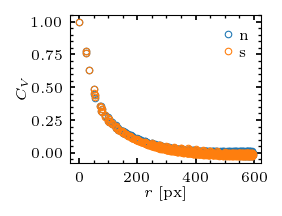

In [161]:
# plot data
count = 0
for kw in avg_r:
    avg_r[kw] = avg_r[kw].sort_values(by=['R'])
    avg_r[kw] = avg_r[kw].loc[avg_r[kw]['R']<600]
    plt.plot(avg_r[kw]['R'], avg_r[kw]['CV'], label=kw, ls='', marker='o', mec=bestcolor(count), mfc=(0,0,0,0),
            mew=0.5, markersize=3)
    count += 1
plt.legend()
plt.xlabel('$r$ [px]')
plt.ylabel('$C_V$')

## 3. Compare spatial correlations and GNF

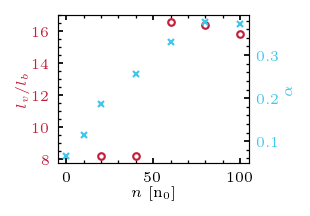

In [172]:
mpp = 0.33
lb = 3 # um
cs = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig2-GNF\conc-slope.csv')
n = [20, 40, 60, 80, 100]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

color = wowcolor(0)
ax1.plot(clv_data['conc'], clv_data['cl']*mpp/lb, ls='', marker='o', mec=color, mfc=(0,0,0,0),
        markersize=3, mew=1)
ax1.set_xlabel('$n$ [n$_0$]')
ax1.set_ylabel('$l_v/l_b$', color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = wowcolor(4)
ax2.plot(cs.conc, cs.slope, ls='', marker='x', mec=color, mfc=(0,0,0,0),
        markersize=3, mew=1)
ax2.set_ylabel('$\\alpha$', color=color)
ax2.tick_params(axis='y', labelcolor=color)

## <font color='gray'>4. Improve the speed of functions corrS and corrI

Although the functions corrS and corrI, which calculates the correlation functions of images and their velocity fields, worked fine in the past, their speed is too slow and cause trouble when I try to load many such jobs on MSI. Here, I try a vectorized implementation, which hopefully can improve the speed of these two functions.

### 4.1 Vectorized function

In the revised function, instead of iterating over all the possible intervals (xin and yin in the function), I shift the original image and calculate the cross correlation between the original image and its corresponding part in the shifted image. This operation avoids the use of two for loops in the code, and speeds the code up dramatically (from 5 min to 5 sec on a typical image from experiment). The idea is illustrated in the picture below:
<img src='temp_data\corrI_vectorization_illustration.jpg'>

In [50]:
def corrI(X, Y, I):
    row, col = I.shape
    I = I - I.mean()
    CI = np.ones(I.shape)
    normalizer = I.std() ** 2
    for xin in range(0, col):
        for yin in range(0, row):
            if xin != 0 or yin != 0:
                I_shift_x = np.roll(I, xin, axis=1)
                I_shift = np.roll(I_shift_x, yin, axis=0)
                CI[yin, xin] = (I[yin:, xin:] * I_shift[yin:, xin:]).mean() / normalizer
    return CI

### 4.2 Compare old function and new function

(-0.5, 1281.5, 1079.5, -0.5)

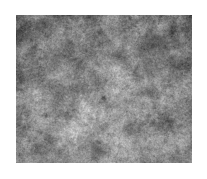

In [2]:
# the test image we are going to use
img = io.imread(r'temp_data\high-conc-sample.tif')
plt.imshow(img, cmap='gray')
plt.axis('off')

(-0.5, 83.5, 69.5, -0.5)

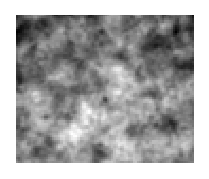

In [62]:
# coarse-grain the image
X, Y, I = corrLib.divide_windows(img, windowsize=[30, 30], step=15)
plt.imshow(I, cmap='gray')
plt.axis('off')

**Note:** we do a high degree coarse-graining to make calculation faster for the old function.

In [63]:
tic = time.monotonic()
CI_old = corrLib.corrI(X, Y, I)
toc = time.monotonic()
t_old = toc - tic
tic = time.monotonic()
CI_new = corrI(X, Y, I)
toc = time.monotonic()
t_new = toc - tic
print('old function: {:.2f} s'.format(t_old))
print('new function: {:.2f} s'.format(t_new))

old function: 6.98 s
new function: 0.33 s


**Note:** when image is large, the speeding up effect is mroe clear.

Text(0.5, 1.0, 'new')

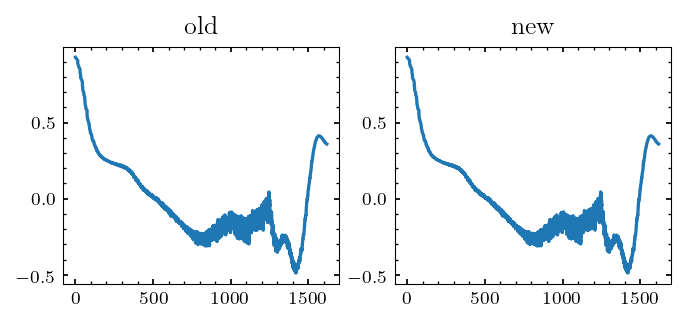

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 2))
table = corrLib.distance_corr(X, Y, CI_old)
ax[0].plot(table.R, savgol_filter(table.C, 101, 3))
ax[0].set_title('old')
table = corrLib.distance_corr(X, Y, CI_new)
ax[1].plot(table.R, savgol_filter(table.C, 101, 3))
ax[1].set_title('new')

**Note:** the results are exactly the same.

### 4.3 Vectorize corrS

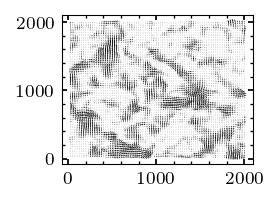

In [70]:
pivData = pd.read_csv('temp_data/piv-sample.csv')
plt.quiver(pivData.x, pivData.y, pivData.u, pivData.v)

In [96]:
def corrS(X, Y, U, V):
    row, col = X.shape
    vsqrt = (U ** 2 + V ** 2) ** 0.5
    U = U - U.mean()
    V = V - V.mean()
    Ax = U / vsqrt
    Ay = V / vsqrt
    CA = np.ones(X.shape)
    CV = np.ones(X.shape)
    for xin in range(0, col):
        for yin in range(0, row):
            if xin != 0 or yin != 0:
                CA[yin, xin] = (Ax[0:row-yin, 0:col-xin] * Ax[yin:row, xin:col] + Ay[0:row-yin, 0:col-xin] * Ay[yin:row, xin:col]).mean()
                CV[yin, xin] = (U[0:row-yin, 0:col-xin] * U[yin:row, xin:col] + V[0:row-yin, 0:col-xin] * V[yin:row, xin:col]).mean() / (U.std()**2+V.std()**2)
    return CA, CV

In [71]:
# prep data
row = len(pivData.y.drop_duplicates())
col = len(pivData.x.drop_duplicates())
mat = {}
for kw in pivData:
    mat[kw] = np.array(pivData[kw]).reshape(row, col)

In [89]:
tic = time.monotonic()
CA_old, CV_old = corrLib.corrS(mat['x'], mat['y'], mat['u'], mat['v'])
toc = time.monotonic()
t_old = toc - tic
tic = time.monotonic()
CA_new, CV_new = corrS(mat['x'], mat['y'], mat['u'], mat['v'])
toc = time.monotonic()
t_new = toc - tic
print('old function: {:.2f} s'.format(t_old))
print('new function: {:.2f} s'.format(t_new))

old function: 44.16 s
new function: 0.84 s


Text(0.5, 1.0, 'CV new')

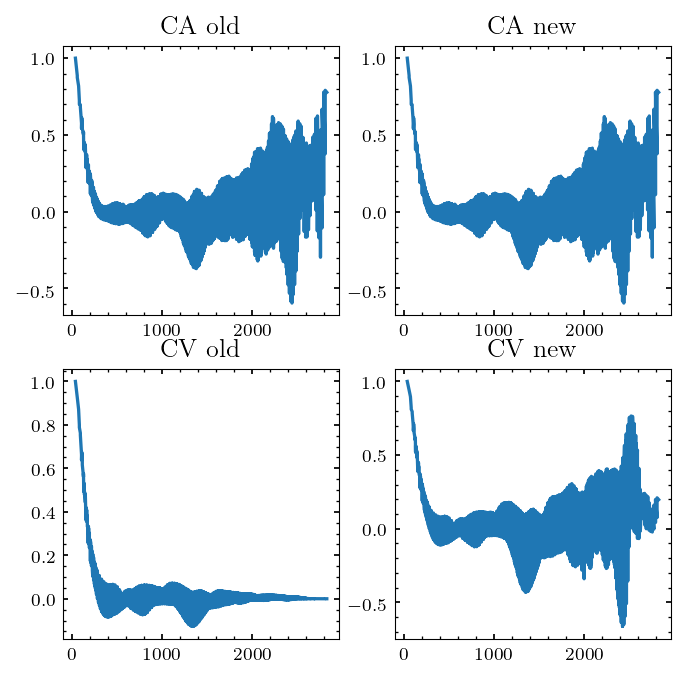

In [94]:
# Compare results
table_a_old = corrLib.distance_corr(mat['x'], mat['y'], CA_old)
table_a_new = corrLib.distance_corr(mat['x'], mat['y'], CA_new)
table_v_old = corrLib.distance_corr(mat['x'], mat['y'], CV_old)
table_v_new = corrLib.distance_corr(mat['x'], mat['y'], CV_new)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
ax[0][0].plot(table_a_old.R, table_a_old.C)
ax[0][0].set_title('CA old')
ax[0][1].plot(table_a_new.R, table_a_new.C)
ax[0][1].set_title('CA new')
ax[1][0].plot(table_v_old.R, table_v_old.C)
ax[1][0].set_title('CV old')
ax[1][1].plot(table_v_new.R, table_v_new.C)
ax[1][1].set_title('CV new')

### 4.4 The coarse-graining function divide_windows can also be vectorized

Currently the way we coarse-grain images is by doing for loops over all pixels (coarse-grain boxes). A even simpler way would eliminate all for loops.

(-0.5, 1281.5, 1079.5, -0.5)

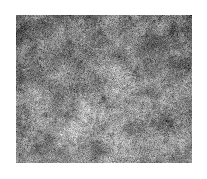

In [97]:
img = io.imread(r'temp_data\high-conc-sample.tif')
plt.imshow(img, cmap='gray')
plt.axis('off')

old method: 0.64 s
new method: 0.09 s
function is sped up 6.8 times


Text(0.5, 1.0, 'new method')

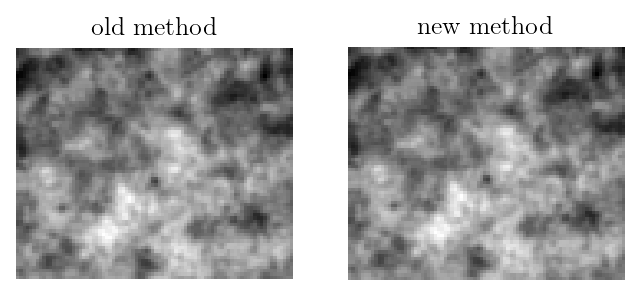

In [130]:
# coarse-grain the image, corrLib.divide_windows
tic = time.monotonic()
count = 0
while count < 10:
    count += 1
    X, Y, I_old = corrLib.divide_windows(img, windowsize=[30, 30], step=15)
toc = time.monotonic()
t_old = toc - tic

# coarse-grain the image, skimage.util.view_as_windows + np.mean
tic = time.monotonic()
count = 0
while count < 10:
    count += 1
    I_new = util.view_as_windows(img, 30, step=15).mean(axis=(2, 3))
toc = time.monotonic()
t_new = toc - tic

print('old method: {:.2f} s'.format(t_old))
print('new method: {:.2f} s'.format(t_new))
print('function is sped up {:.1f} times'.format(t_old/t_new))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 2))
ax[0].imshow(I_old, cmap='gray')
ax[0].axis('off')
ax[0].set_title('old method')

ax[1].imshow(I_new, cmap='gray')
ax[1].axis('off')
ax[1].set_title('new method')

**Comment:** by utilizing functions from skimage (view as windows) and numpy (mean), the coarse-graining function is sped up 6.8 times, compared to the "for loop method" I used in the past.

### 4.5 PIV bug test

When running my custom PIV code, two types of problems are encountered:

- in smoothn, the smoothing function, I get 
```
MATLAB:smoothn:SUpperBound
s = 125000.250 : the upper bound for s has been reached. Put s as an input variable if required.
```

- in the main PIV, I get
```
/home/xcheng/liux3141/code/Python/PIV/openpiv-python/openpiv/pyprocess.py:264: RuntimeWarning: divide by zero encountered in log
  subp_peak_position = (peak1_i + ((log(cl) - log(cr)) / (2 * log(cl) - 4 * log(c) + 2 * log(cr))),
```

Here I test a small image sequence which should give me these two problems, and try to fix them. Since I study kinetics of collective motions, the images typically consist two types - dark and bright. Both cases are tested.

In [2]:
dark_img_folder = 'temp_data/PIV-bug-test/dark'
bright_img_folder = 'temp_data/PIV-bug-test/bright'

In [13]:
from pivLib import PIV1
I0 = io.imread(os.path.join(bright_img_folder, '2000.tif'))
I1 = io.imread(os.path.join(bright_img_folder, '2001.tif'))
frame_data = PIV1(I0, I1, 50, 25, 0.033, smooth=True)

MATLAB:smoothn:SLowerBound
s = 0.029 : the lower bound for s has been reached. Put s as an input variable if required.
MATLAB:smoothn:SLowerBound
s = 0.029 : the lower bound for s has been reached. Put s as an input variable if required.


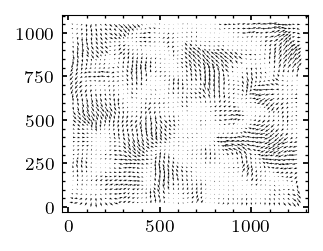

In [17]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# ax.imshow(I0, cmap='gray')
ax.quiver(frame_data.x, frame_data.y, frame_data.u, frame_data.v)

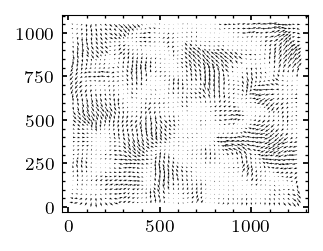

In [18]:
frame_data = pd.read_csv('temp_data/piv2.csv')
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.quiver(frame_data.x, frame_data.y, frame_data.u, frame_data.v)

### 4.6 improve distance_corr

The function `distance_corr` was designed to convert a 2D correlation function into a 1D version, where distance is the only variable. The current version of `distance_corr` relies on for loops over both axis and can potentially be improved by getting rid of the for loops. Let's test it below.

In [24]:
corr_data = pd.read_csv('temp_data/xy_corr.csv')
col = len(corr_data.X.drop_duplicates())
row = len(corr_data.Y.drop_duplicates())
X = np.array(corr_data.X).reshape(row, col)
Y = np.array(corr_data.Y).reshape(row, col)
C = np.array(corr_data.CA).reshape(row, col)

In [34]:
%%time
r_corr = corrLib.distance_corr(X, Y, C)
r_corr.head()

Wall time: 21 ms


,R,C
0,35.355339,1.000000
80,55.901699,0.923351
1,55.901699,0.915943
81,70.710678,0.870433
160,79.056942,0.801452


In [42]:
# redefine distance_corr
def distance_corr(X, Y, C):
    r_corr = pd.DataFrame({'R': (X.flatten()**2 + Y.flatten()**2) ** 0.5, 'C': C.flatten()}).sort_values(by='R')
    return r_corr

In [43]:
%%time
r_corr = distance_corr(X, Y, C)
r_corr.head()

Wall time: 3 ms


,R,C
0,35.355339,1.000000
80,55.901699,0.923351
1,55.901699,0.915943
81,70.710678,0.870433
160,79.056942,0.801452


### 4.7 Improve div_field

The function `div_field` was designed to compute the divergence of velocity fields from PIV data. The current version of the function has a for loop over every single velocity in PIV. Here I try to vectorize it to make it faster.

In [51]:
img = io.imread('temp_data/0420.tif')
pivData = pd.read_csv('temp_data/piv2.csv')
winsize = 50
step = 25

In [57]:
%%time
c, v, divcn, divcv, divv = corrLib.div_field(img, pivData, winsize, step)
divv.flatten()

Wall time: 20 ms


array([-1.6605775 , 12.33180913, 10.44246721, ...,  0.        ,
        0.        ,  0.        ])

In [58]:
import cv2

In [55]:
# redefine div_field
def div_field(img, pivData, winsize, step):
    X, Y, I = divide_windows(img, windowsize=[winsize, winsize], step=step)
    # concentration field
    I0 = 255
    c = I0 - I
    
    # calculation for divcn and divcv
    row, col = I.shape
    vx = np.array(pivData.u).reshape(I.shape)
    vy = np.array(pivData.v).reshape(I.shape)
    v = (vx**2 + vy**2)**.5
    nx = np.array(pivData.u / (pivData.u**2 + pivData.v**2)**.5).reshape(I.shape)
    ny = np.array(pivData.v / (pivData.u**2 + pivData.v**2)**.5).reshape(I.shape)
    cnx = c * nx
    cny = c * ny
    cvx = c * vx
    cvy = c * vy
#     divcn = np.zeros(I.shape)
#     divcv = np.zeros(I.shape)
#     divv = np.zeros(I.shape)
    
    # the unit of returned velocity gradient is px/s / px == /s
    kernelx = np.array([[-1, 1], [-1, 1]]).astype('float32')
    kernely = np.array([[-1, -1], [1, 1]]).astype('float32')
    divcn = cv2.filter2D(cnx, -1, kernelx) + cv2.filter2D(cny, -1, kernely)
    divcv = cv2.filter2D(cvx, -1, kernelx) + cv2.filter2D(cvy, -1, kernely)
    divv = cv2.filter2D(vx, -1, kernelx) + cv2.filter2D(vy, -1, kernely)  

array([-1.6605775 , 12.33180913, 10.44246721, ...,  0.        ,
        0.        ,  0.        ])

In [76]:
X, Y, I = corrLib.divide_windows(img, windowsize=[50, 50], step=25)
I.shape

(42, 50)

In [92]:
kernel = np.array([[-1, -1], [1, 1]]).astype('float32')
u = np.array(pivData.u).reshape(42, 50)
f = cv2.filter2D(u, -1, kernel)
f.min()

-42.5102907698801

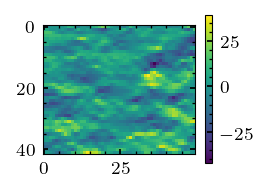

In [93]:
plt.imshow(f)
plt.colorbar()

## 4. Density correlation function in Fourier space

Quite a few theory papers like to investigate density correlation and fluctuation in Fourier space. I don't get it yet how it works. I will try to figure it out if I have time. 

In [28]:
I = np.random.randn(100, 100)
I[I < 0.9] = 0